In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

**Hyperparameters**

In [25]:
class Para():
    def __init__(self):
        self.latent_dim = 10 # latent space dimention
        self.img_shape = (1, 28, 28) # image shape (1x28x28 for MNIST)
        self.generator_path = 'G_l10.pth' # pre-trained generator path
        self.discriminator_path = 'D_l10.pth' # pre-trained discriminator path
        self.batch_size = 25 # batch size for visualization
        
opt = Para()

**Network architectures**

In [26]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(opt.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *opt.img_shape)
        return img

    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(opt.img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

    
# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

**Load networks**

In [27]:
generator.load_state_dict(torch.load(opt.generator_path))
discriminator.load_state_dict(torch.load(opt.discriminator_path))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

**Generator and discriminator visualization**

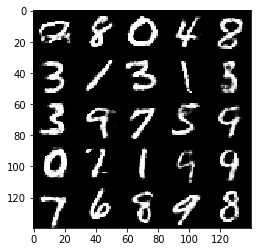

In [51]:
z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim)))) # latend variables

with torch.no_grad():
    generated_imgs = generator(z) # generate images
    validity = discriminator(generated_imgs) # discriminator validaty

imgs = torchvision.utils.make_grid(generated_imgs, nrow=int(np.sqrt(opt.batch_size)), padding=0, normalize=True)

if cuda:
    plt.imshow(imgs.permute(1, 2, 0).cpu())
else:
    plt.imshow(imgs.permute(1, 2, 0))
plt.show()